In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
pdf_trn = pd.read_csv("../input/train.csv")
pdf_tst  = pd.read_csv("../input/test.csv")

In [3]:
def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)

### The data consists of different segments which can be sorted into one of 5 "signal groups":

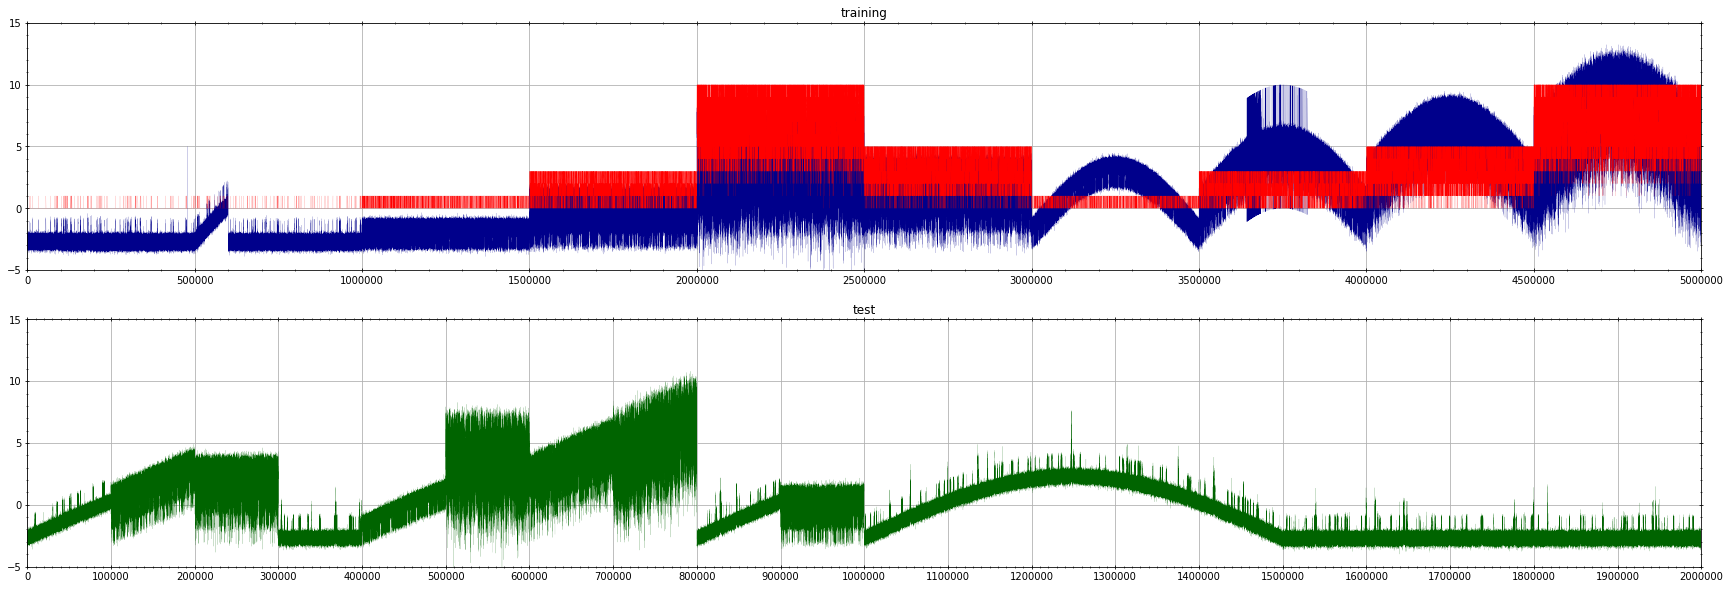

In [4]:
fig, axes = create_axes_grid(1,2,30,5)
set_axes(axes[0], x_val=[0,5000000,500000,100000], y_val=[-5,15,5,1])
axes[0].plot(pdf_trn['signal'], color='darkblue', linewidth=.1)
axes[0].plot(pdf_trn['open_channels'], color='red', linewidth=.1, linestyle='--')
axes[0].set_title('training')
set_axes(axes[1], x_val=[0,2000000,100000,10000], y_val=[-5,15,5,1])
axes[1].set_title('test')
axes[1].plot(pdf_tst['signal'], color='darkgreen', linewidth=.1)

### Visual identification can easily determine a) the signal group and b) whether there is a drift:

In [8]:
trn_segm_sep = np.concatenate([[0,500000,600000], np.arange(1000000,5000000+1,500000)])

In [9]:
trn_segm_sep = np.concatenate([[0,500000,600000], np.arange(1000000,5000000+1,500000)])
trn_segm_sgnl_grps = [0,0,0,1,2,4,3,1,2,3,4] # from visual identification
trn_segm_shifted = [False, True, False, False, False, False, False, True, True, True, True] # from visual identification
trn_sgnl = np.split(pdf_trn['signal'].values, trn_segm_sep[1:-1])
trn_opench = np.split(pdf_trn['open_channels'].values, trn_segm_sep[1:-1])

In [10]:
tst_segm_sep = np.concatenate([np.arange(0,1000000+1,100000), [1500000,2000000]])
tst_segm_sgnl_grps = [0,2,3,0,1,4,3,4,0,2,0,0] # from visual id
tst_segm_shifted = [True, True, False, False, True, False, True, True, True, False, True, False] # from visual id
tst_sgnl = np.split(pdf_tst['signal'].values, tst_segm_sep[1:-1])

### The training data segments 0,3,4,6,5 are the "model segments" for the signal groups 0-5, respectively (clean & no shift):

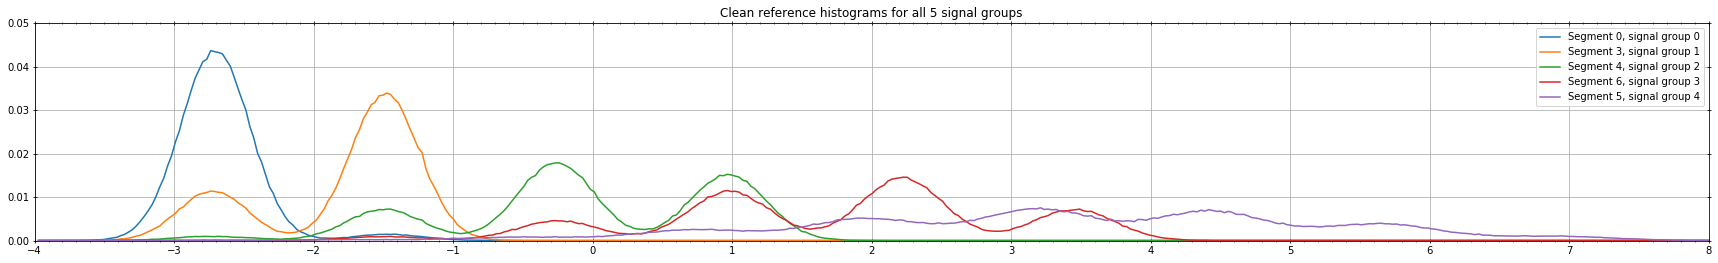

In [11]:
#create clean signal histograms
_, axes_hist = create_axes_grid(1,1,30,4)
set_axes(axes_hist, x_val=[-4,8,1,.1], y_val=[0,0.05,0.01,0.01])

clean_hist = []
hist_bins = np.linspace(-4,10,500)

for j, i in enumerate([0, 3, 4, 6,5 ]):
    clean_hist.append(np.histogram(trn_sgnl[i], bins=hist_bins)[0])
    clean_hist[-1] = clean_hist[-1] / 500000 # normalize histogram
    axes_hist.plot(hist_bins[1:], clean_hist[-1], label='Segment '+str(i)+', signal group '+str(j));
axes_hist.legend();
axes_hist.set_title("Clean reference histograms for all 5 signal groups");

### Let's take a look at the linear shift in segment 1 and compare the histogram of 4 slices of width 1000 (at 0,25000,50000 and 75000) to the clean histogram of segment 0:
#### cell below:
- four histogram waves belong to the same group but taken at different place in the time series (same window size as well).
- It's visually clear that the shift can be determined by matching the window histograms to the clean histogram. Now we need to do this automatically for all shifted data segments:

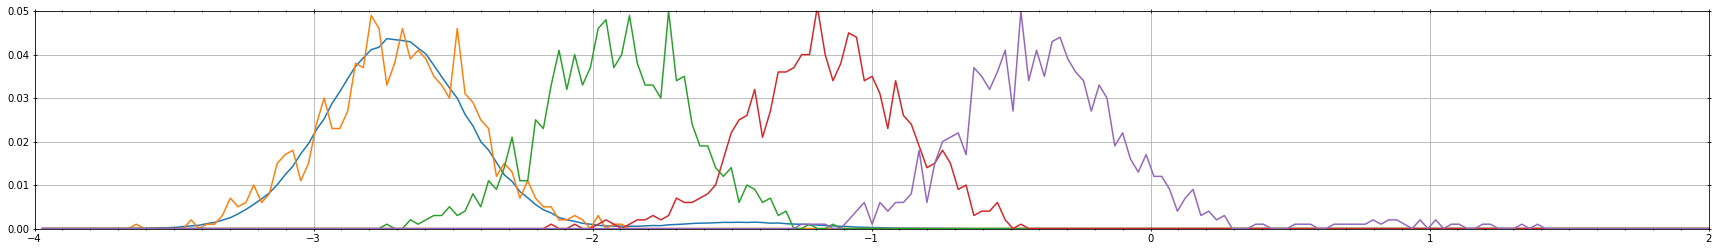

In [12]:
window_size = 1000

fig, axes_investigate = create_axes_grid(1,1,30,4)
set_axes(axes_investigate, x_val=[-4,2,1,.1], y_val=[0,0.05,0.01,0.01])

axes_investigate.plot(hist_bins[1:], clean_hist[0]);
for i in [0,25000,50000,75000]:
    window_hist = np.histogram(trn_sgnl[1][i:i+window_size], bins=hist_bins)[0] / window_size
    axes_investigate.plot(hist_bins[1:], window_hist);

### It's visually clear that the shift can be determined by matching the window histograms to the clean histogram. Now we need to do this automatically for all shifted data segments:

In [13]:
window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10 # maximum absolute change in shift from window to window+1
trn_sgnl_shift = []

In [14]:
# loop through groups
for clean_id in range(len(trn_segm_sgnl_grps)):
    # get group id
    group_id = trn_segm_sgnl_grps[clean_id]
    # reset window shift for each group
    window_shift = []
    prev_s = 0 # all signal groups start with shift=0
    window_data = trn_sgnl[clean_id].reshape(-1, window_size)
    
    #break
    
    for w in window_data:
        # get histogram for each window and divide by window size
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        # for window shift between -10 and 10 inclusive, roll the window histogram, and element-wise multiply the clean histogram, and then sum
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        # reset pres_s
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    trn_sgnl_shift.append(window_shift) 

### This results in an already quite clean shift signal:

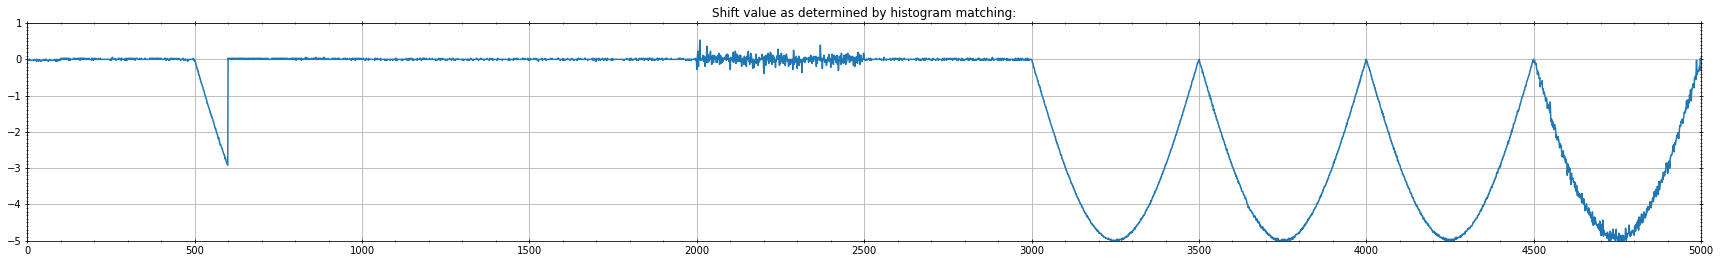

In [15]:
_, axes_cleaned = create_axes_grid(1,1,30,4)
set_axes(axes_cleaned, x_val=[0,5000,500,100], y_val=[-5,1,1,.1])
axes_cleaned.plot(np.concatenate(trn_sgnl_shift));
axes_cleaned.set_title("Shift value as determined by histogram matching:");

### Finally, approximation by a 4th order polynomial:

In [16]:
trn_sgnl_shift_clean = []
trn_sgnl_detrend = []

for data, use_fit, signal in zip(trn_sgnl_shift, trn_segm_shifted, trn_sgnl):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    trn_sgnl_shift_clean.append(data_2)
    trn_sgnl_detrend.append(signal + data_2)

### The final shift and the cleaned signal:

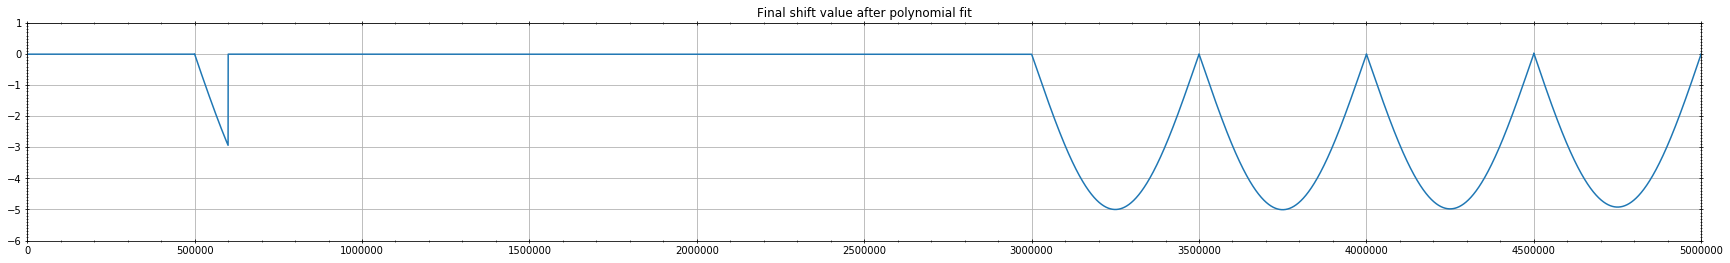

In [17]:
_, axes_final = create_axes_grid(1,1,30,4)
set_axes(axes_final, x_val=[0,5000000,500000,100000], y_val=[-6,1,1,.1])
axes_final.plot(np.concatenate(trn_sgnl_shift_clean));
axes_final.set_title("Final shift value after polynomial fit");

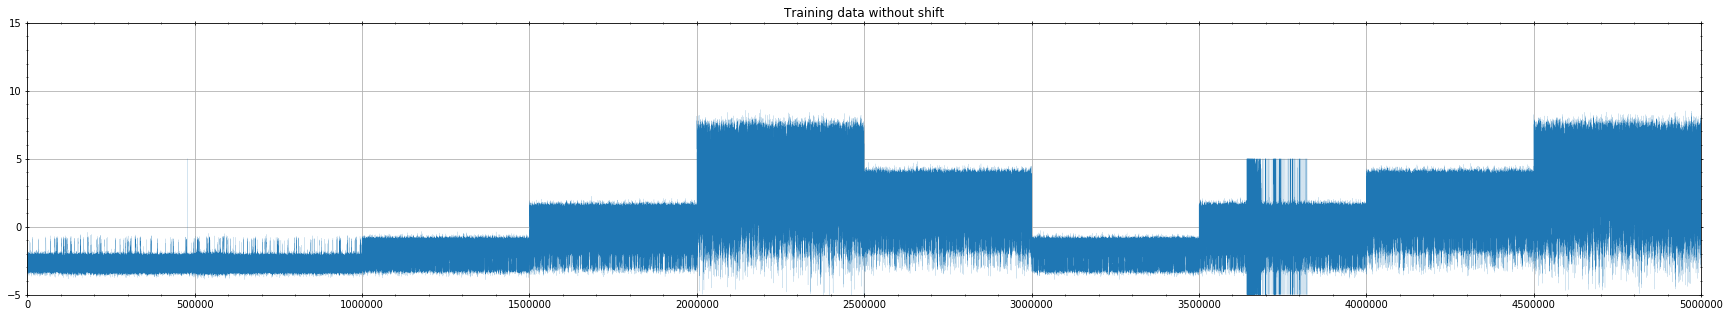

In [18]:
_, axes_final_signal = create_axes_grid(1,1,30,5)
set_axes(axes_final_signal, x_val=[0,5000000,500000,100000], y_val=[-5,15,5,1])
axes_final_signal.plot(np.concatenate(trn_sgnl_detrend), linewidth=.1);
axes_final_signal.set_title("Training data without shift");

### And the same procedure for the test data:

In [19]:
window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10
tst_sgnl_detrend = []
tst_sgnl_shift = []

for clean_id in range(len(tst_segm_sgnl_grps)):
    
    group_id = tst_segm_sgnl_grps[clean_id]
    window_shift = []
    prev_s = 0
    window_data = tst_sgnl[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    tst_sgnl_shift.append(window_shift)    

In [20]:
tst_sgnl_shift_clean = []
tst_sgnl_detrend = []
tst_remove_shift = [True, True, False, False, True, False, True, True, True, False, True, False]

for data, use_fit, signal in zip(tst_sgnl_shift, tst_segm_shifted, tst_sgnl):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    tst_sgnl_shift_clean.append(data_2)
    tst_sgnl_detrend.append(signal + data_2)

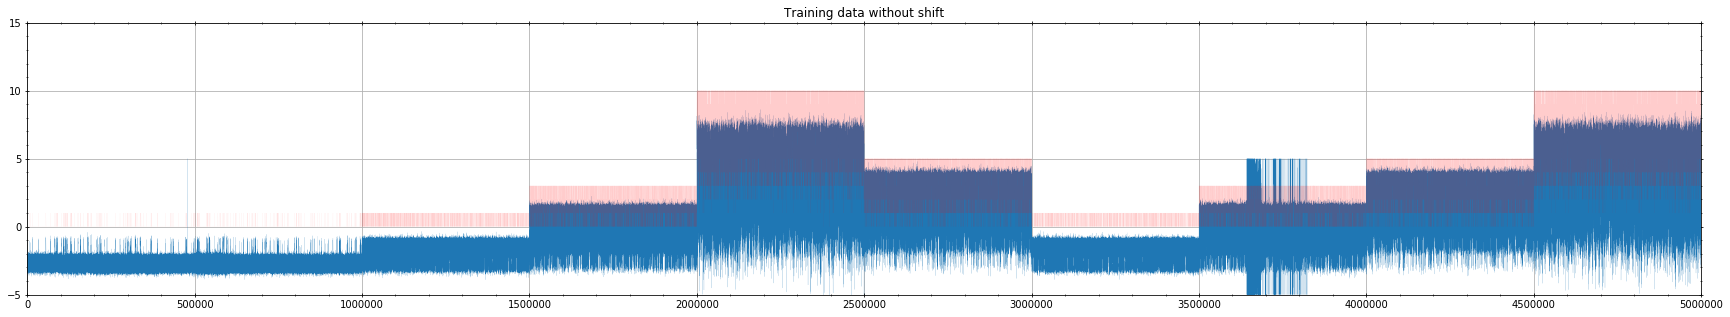

In [22]:
_, axes_final_signal = create_axes_grid(1, 1, 30, 5)
set_axes(axes_final_signal, x_val=[0,5000000,500000,100000], y_val=[-5,15,5,1])
axes_final_signal.plot(np.concatenate(trn_sgnl_detrend), linewidth=.1);
axes_final_signal.plot(pdf_trn['open_channels'], color='red', linewidth=.1, linestyle='--', alpha=.2)
axes_final_signal.set_title("Training data without shift");

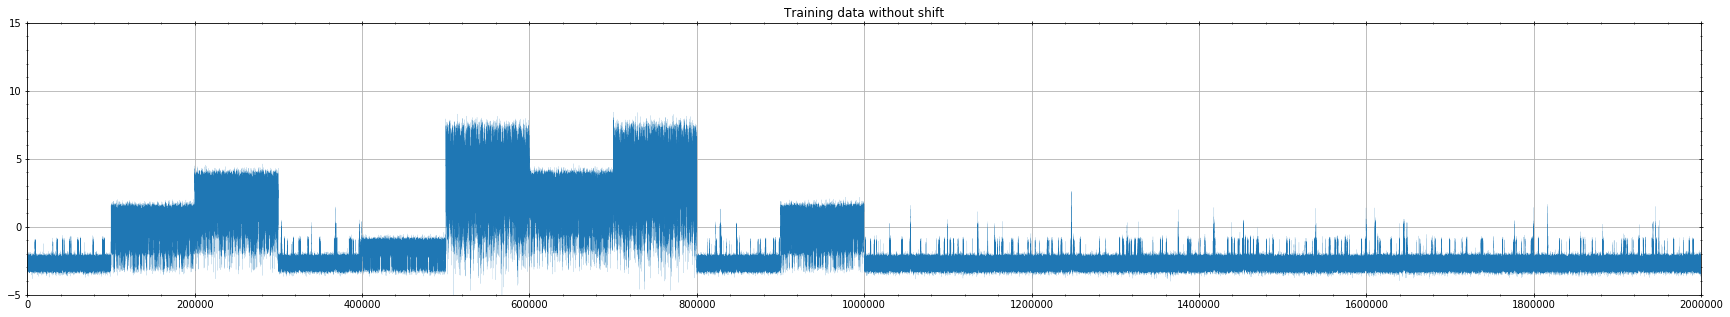

In [25]:
_, axes_final_test_signal = create_axes_grid(1,1,30,5)
set_axes(axes_final_test_signal, x_val=[0,2000000,200000,40000], y_val=[-5,15,5,1])
axes_final_test_signal.plot(np.concatenate(tst_sgnl_detrend), linewidth=.1);
axes_final_test_signal.set_title("Testing data without shift");

In [19]:
np.concatenate(trn_sgnl_detrend).shape

(5000000,)

In [24]:
np.concatenate(tst_sgnl_detrend)

array([-2.67534728, -2.87497894, -2.88561059, ..., -2.8285    ,
       -2.9092    , -2.7422    ])

### save data